In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm

In [2]:
transform = transforms.Compose(
[
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
mnist = torchvision.datasets.MNIST('../data', train=True, download=True,\
                                  transform=transform)

batch_size = 50
loader = torch.utils.data.DataLoader(mnist, batch_size=batch_size, \
                                          shuffle=True, num_workers=2)

Processing...
Done!


In [3]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

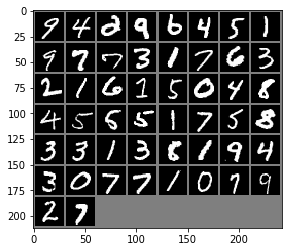

Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/francois/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/francois/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/francois/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/francois/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/francois/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/francois/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/fran

In [4]:
dataiter = iter(loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

## MLP

In [4]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [18]:
batch_size = 50
n_epochs = 20
lr = 1e-3
z_size = 100
dim = 784

G = Generator(z_size, 400, dim)
D = Discriminator(dim, 400, 1)

g_optimiser = optim.SGD(G.parameters(), lr=lr)
d_optimiser = optim.SGD(D.parameters(), lr=lr)

#fixed_noise = torch.FloatTensor(batch_size, z_size).normal_(0,1)

In [ ]:
for epoch in tqdm(range(n_epochs)):
    for data in loader:
        img, label = data
        img = Variable(img.view(batch_size,dim))

        D.zero_grad()
        #real data
        d_real = D(img)
        d_real_error = -torch.mean(torch.log(d_real))
        d_real_error.backward()
        #fake data
        noise = torch.FloatTensor(batch_size, z_size).normal_(0,1)
        noise = Variable(noise)
        fake_data = G(noise)
        d_fake = D(fake_data.detach())
        d_fake_error = -torch.mean(torch.log(1-d_fake))
        d_fake_error.backward()
        d_optimiser.step()

        G.zero_grad()
        d_output = D(fake_data)
        g_error = -torch.mean(torch.log(d_output))
        g_error.backward()
        g_optimiser.step()
        
    a = fake_data.data.view(batch_size, 1, 28, 28)
    imshow(torchvision.utils.make_grid(a))

## DCGAN

In [5]:
class DCG(nn.Module):
    def __init__(self, zdim=100):
        super(DCG, self).__init__()
        self.main = nn.Sequential(
            #1x1
            nn.ConvTranspose2d(zdim, 8, 7, 1, 0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            #7x7
            nn.ConvTranspose2d(8, 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            #14x14
            nn.ConvTranspose2d(4, 1, 4, 2, 1, bias=False),
            #28x28 -> output
            nn.Tanh()
        )
        
    def  forward(self, x):
        return self.main(x)
    
class DCD(nn.Module):
    def __init__(self):
        super(DCD, self).__init__()
        self.main = nn.Sequential(
            #28x28
            nn.Conv2d(1, 4, 4, 2, 1),
            nn.BatchNorm2d(4),
            nn.LeakyReLU(0.2, inplace=True),
            #14x14
            nn.Conv2d(4, 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2, inplace=True),
            #7x7
            nn.Conv2d(8, 1, 7, 1, 0, bias=False),
            # 1x1
            nn.Sigmoid()
        )
        
    def  forward(self, x):
        output = self.main(x)
        return output.view(-1, 1).squeeze(1)

In [8]:
batch_size = 50
n_epochs = 20
lr = 1e-4
z_size = 100

G = DCG(z_size)
D = DCD()

g_optimiser = optim.Adam(G.parameters(), lr=lr)
d_optimiser = optim.SGD(D.parameters(), lr=lr)

criterion = nn.BCELoss()

In [10]:
z = Variable(torch.FloatTensor(batch_size, z_size, 1, 1).normal_(0,1))
a = G(z)
print(a)
b = D(G(z))
print(b)

Variable containing:
(0 ,0 ,.,.) = 
  0.0006  0.0292  0.0348  ...   0.0174  0.0085  0.0254
 -0.0063 -0.0198 -0.0014  ...  -0.0455  0.0309 -0.0067
  0.0407  0.0207  0.0424  ...   0.0189 -0.0188  0.0170
           ...             ⋱             ...          
 -0.0061  0.0093  0.0021  ...   0.0044 -0.0056 -0.0050
  0.0086 -0.0124  0.0127  ...  -0.0082  0.0185  0.0044
  0.0031 -0.0012 -0.0025  ...   0.0000  0.0000  0.0000
     ⋮ 

(1 ,0 ,.,.) = 
  0.0040 -0.0292 -0.0380  ...   0.0179  0.0158  0.0313
  0.0017  0.0033  0.0408  ...  -0.0234  0.0318 -0.0220
  0.1331  0.0621 -0.0238  ...   0.0168 -0.0027  0.0331
           ...             ⋱             ...          
  0.0023 -0.0299  0.0095  ...  -0.0064 -0.0001 -0.0137
  0.0205 -0.0096  0.0127  ...  -0.0163  0.0153  0.0140
  0.0072  0.0068  0.0005  ...   0.0000  0.0000  0.0000
     ⋮ 

(2 ,0 ,.,.) = 
  0.0000  0.0004  0.0001  ...  -0.0024 -0.0103  0.0011
  0.0000 -0.0135 -0.0065  ...  -0.0277  0.0232 -0.0059
  0.0000  0.0121  0.0161  ...   0.02

In [15]:
batch_size =50
n_epochs = 10
lr = 1e-4
z_size = 100

G = DCG(z_size)
D = DCD()

g_optimiser = optim.Adam(G.parameters(), lr=lr)
d_optimiser = optim.Adam(D.parameters(), lr=lr)

criterion = nn.BCELoss()

ones = Variable(torch.ones(batch_size))
zeros = Variable(torch.zeros(batch_size))

In [16]:
for epoch in tqdm(range(1)):
    for data in loader:
        img, label = data
        img = Variable(img)
        
        # discriminator step
        D.zero_grad()
        #real data
        d_real = D(img)
        d_real_error = criterion(d_real, ones)
        d_real_error.backward()
        #fake data
        noise = torch.FloatTensor(batch_size, z_size, 1, 1).normal_(0,1)
        noise = Variable(noise)
        fake_data = G(noise)
        d_fake = D(fake_data.detach())
        d_fake_error = criterion(d_fake, zeros)
        d_fake_error.backward()
        d_optimiser.step()
    
        # generator step
        G.zero_grad()
        z = torch.FloatTensor(batch_size, z_size, 1, 1).normal_(0,1)
        z = Variable(z)
        gen_data = G(z)
        d_output = D(gen_data)
        g_error = criterion(d_output, ones)
        g_error.backward()
        g_optimiser.step()


  0%|          | 0/1 [00:00<?, ?it/s]


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/francois/anaconda3/envs/pytorch/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/francois/anaconda3/envs/pytorch/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/francois/anaconda3/envs/pytorch/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 1/1 [00:39<00:00, 39.84s/it]


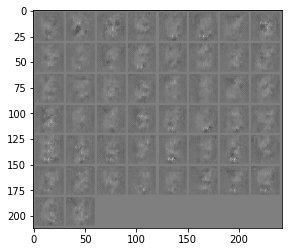

In [17]:
z = torch.FloatTensor(batch_size, z_size, 1, 1).normal_(0,1)
z = Variable(z)
samples = G(z)
imshow(torchvision.utils.make_grid(samples.data))

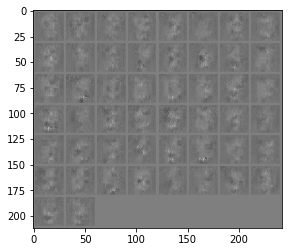

In [18]:
z = torch.FloatTensor(batch_size, z_size, 1, 1).normal_(0,1)
z = Variable(z)
samples = G(z)
imshow(torchvision.utils.make_grid(samples.data))